## Introduction
After completing the We have now used FloPy to demonstrate the impacts of dispersion and heterogeneity. The goal of this notebook is to illustrate the impact of different chemical reactions on transport.

Import the standard libraries

In [73]:
# Import the flopy library
import flopy
# Import a few additional libraries
import sys
import os
# In addition to our typical libraries
import numpy as np
import matplotlib.pyplot as plt

First find where you have your MODFLOW and MT3D executables located on your system.

In [74]:
# Path to MODFLOW executable, probably called 'mf2005'
exe_name_mf = 'C:\\Hydro\\MF2005.1_12\\MF2005.1_12\\bin\\mf2005'
# Print to make sure it is formated correctly
print(exe_name_mf)
# Path to MT3D executable, probably called 'mt3dms'
exe_name_mt = 'C:\\Hydro\\mt3dusgs1.1.0\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'
# Print to make sure it is formated correctly
print(exe_name_mt)

C:\Users\zahas\Dropbox\Research\Simulation\modflow\executables\mf2005
C:\Users\zahas\Dropbox\Research\Simulation\modflow\executables\mt3dms


Let's create a new directory to save the data. 

In [75]:
# directory to save data
directory_name = 'reactions_1D_models'
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
workdir = os.path.join('.', directory_name)

Notice however that we don't yet name the folder where we will save data 'dirname'. This will be an input to our model function.


## 1D Reactions Model Function
The first thing we do is setup the function. The input variables are:

### Function Input:
#### directory name
    direname = 

#### period length 
Time is in selected units, the model time length is the sum of this (for steady state flow it can be set to anything). The format for multi-period input: [60., 15*60]
 
    perlen_mf = 
    
#### advection velocity

    v = 
    
#### dispersivity
Set the longitudinal dispersivity in selected units. What are the units again?

    al = 
  
### Reaction model input  
#### Model type
isothm is a flag indicating which type of sorption (or dual-domain mass transfer) is simulated: isothm = 0, no sorption is simulated; isothm = 1, linear isotherm (equilibrium-controlled); isothm = 2, Freundlich isotherm (equilibrium-controlled); isothm = 3, Langmuir isotherm (equilibrium-controlled); isothm = 4, first-order kinetic sorption (nonequilibrium); isothm = 5, dual-domain mass transfer (without sorption); isothm = 6, dual-domain mass transfer (with sorption). (default is 0). In this class we will only cover the first four models.

    isothm = 
    
#### ireact 
ireact is an integer flag indicating which type of kinetic rate reaction is simulated: ireact = 0, no kinetic rate reaction is simulated; ireact = 1, first-order irreversible reaction, ireact = 100, zero-order reactions (decay or production). Note that this reaction package is not intended for modeling chemical reactions between species. An add-on reaction package developed specifically for that purpose may be used. (default is 0).

#### bulk density (rhob)
This can be a float or array of floats (nlay, nrow, ncol). rhob is the bulk density of the aquifer medium (unit, ML-3). rhob is used if isothm = 1, 2, 3, 4, or 6. If rhob is not user-specified and isothm is not 5 then rhob is set to 1.8e3. (default is None)


#### First sorption parameter (sp1)
Can be a float or array of floats (nlay, nrow, ncol). The use of sp1 depends on the type of sorption selected (the value of isothm). For linear sorption (isothm = 1) and nonequilibrium sorption (isothm = 4), sp1 is the distribution coefficient (Kd) (unit, L3M-1). For Freundlich sorption (isothm = 2), sp1 is the Freundlich equilibrium constant (Kf) (the unit depends on the Freundlich exponent a). For Langmuir sorption (isothm = 3), sp1 is the Langmuir equilibrium constant (Kl) (unit, L3M-1 ). For dual-domain mass transfer without sorption (isothm = 5), sp1 is not used, but still must be entered. For dual-domain mass transfer with sorption (isothm = 6), sp1 is also the distribution coefficient (Kd) (unit, L3M-1). If sp1 is not specified and isothm > 0 then sp1 is set to 0. (default is None).

For example 
    
    isothm = 1
    sp1 = kd 

Where 
    
    kd = (retardation - 1.) * prsity / rhob

#### Second sorption parameter (sp2)
sp2 can be a float or array of floats (nlay, nrow, ncol). The use of sp2 depends on the type of sorption model selected. For linear sorption (isothm = 1), sp2 is read but not used. For Freundlich sorption (isothm = 2), sp2 is the Freundlich exponent a. For Langmuir sorption (isothm = 3), sp2 is the total concentration of the sorption sites available ( S ) (unit, MM-1). For nonequilibrium sorption (isothm = 4), sp2 is the first-order mass transfer rate between the dissolved and sorbed phases (beta unit, T-1).  If sp2 is not specified and isothm > 0 then sp2 is set to 0. (default is None).

rc1 float or array of floats (nlay, nrow, ncol)
rc1 is the first-order reaction rate for the dissolved (liquid) phase for the first species (unit, T-1). rc1 is not used ireact = 0. If a dual-domain system is simulated, the reaction rates for the liquid phase in the mobile and immobile domains are assumed to be equal. If rc1 is not specified and ireact > 0 then rc1 is set to 0. (default is None).

rc2 float or array of floats (nlay, nrow, ncol)
rc2 is the first-order reaction rate for the sorbed phase for the first species (unit, T-1). rc2 is not used ireact = 0. If a dual-domain system is simulated, the reaction rates for the sorbed phase in the mobile and immobile domains are assumed to be equal. Generally, if the reaction is radioactive decay, rc2 should be set equal to rc1, while for biodegradation, rc2 may be different from rc1. Note that rc2 is read but not used, if no sorption is included in the simulation. If rc2 is not specified and ireact > 0 then rc2 is set to 0. (default is None).



In [76]:
def reaction_model_1D(dirname, perlen_mf, v, al, isothm, rhob, sp1, sp2):
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 1 # MODFLOW
    mt_tunit = 'S' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 3 # MODFLOW units
    mt_lunit = 'CM' # MT3D units
    
    # number of stress periods (MF input), calculated from period length input
    nper = len(perlen_mf)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = 100
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # Model information 
    nlay = 1 # number of layers
    nrow = 1 # number of rows
    ncol = 101 # number of columns
    delr = 0.1 # grid size in direction of Lx
    delc = 4.4 # grid size in direction of Ly, this was choosen such that the model has the same cross-sectional area as the column from the dispersion notebook example
    delv = 4.4 # grid size in direction of Lz
    laytyp = 0
    
    # length of model in selected units 
    Lx = (ncol - 1) * delr
    print("Model length is: " + str(Lx + delr) + " (check units of 'lenuni')")
    
    # hydraulic conductivity
    hk = 1.
    # advection velocity (function input)
    # v = 0.014
    # porosity
    prsity = 0.3
    # discharge (again in selected units)
    q = v * prsity
    
    # Flow field boundary conditions
    # boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    # index the inlet cell
    ibound[0, 0, 0] = -1
    # index the outlet cell
    ibound[0, 0, -1] = -1
    # constant head conditions
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    h1 = q * Lx
    # index the inlet cell
    strt[0, 0, 0] = h1
    
    # Solute transport boundary conditions
    # Concentration at inlet boundary
    c0 = 1.

    # Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
    # If icbund < 0, the cell is a constant-concentration cell; 
    # If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
    icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
    icbund[0, 0, 0] = -1 # constant-concentration cell

    # Initial conditions: concentration zero everywhere, except the inlet
    sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
    sconc[0, 0, 0] = c0
    
    
    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # MODFLOW package class
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS Model Class
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nprs=nprs, timprs=timprs)
    dceps = 1.e-5
    nplane = 1
    npl = 0 # number of initial particles per cell to be placed in cells with a concentration less than 'dceps'
    nph = 4
    npmin = 0
    npmax = 8 # maximum number of particles allowed per cell
    nlsink = nplane
    npsink = nph
    
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics, this seems to result in minimal numerical dispersion.
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    mixelm = 1
    
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)
    
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    
    # =============================================================================    
    ## Note this additional line to call the 
    rct = flopy.mt3d.Mt3dRct(mt, isothm=1, ireact=1, igetsc=0, rhob=rhob, sp1=kd, 
                               rc1=lambda1, rc2=lambda1)
    # =============================================================================
    ssm = flopy.mt3d.Mt3dSsm(mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    # Extract the output time information, convert from list to np array
    times = np.array(ucnobj.get_times())
    # Extract the 4D concentration values (t, x, y, z)
    conc = ucnobj.get_alldata()
    
    return mf, mt, times, conc

Now lets trying running a model by calling our 'model_1D' function

In [77]:
# model_1D(dirname, perlen_mf, v, al, mixelm)
dirname = 'run1'
perlen_mf = [30*60] 
v = 0.014
al = 0.3 # cm

# Call the FloPy model function
mf, mt, times, conc = model_1D(dirname, perlen_mf, v, al)

.\data_1D_model\run1
Model length is: 10.0 (check units of 'lenuni')


Now let's plot the model output as a function of time

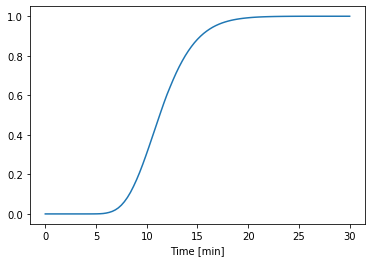

In [78]:
C_btc = conc[:, 0, 0, -1]
plt.plot(times/60, C_btc, label='Breakthrough Curve')
plt.xlabel('Time [min]');

## 1D Analytical Solution Function
Now lets compare the numerical results with the analytical solution we looked at in our previous notebook.

In [79]:
# Remember that we need a few special functions
from scipy.special import erfc as erfc
from scipy.special import erf as erf

# Type 1 inlet conditions
def analytical_model_1D_t1(x, t, v, al):
    # Dispersion
    D = v*al
    # Analytical solution: See lecture slides or (Parker and van Genuchten, 1984) for details
    # Note that the '\' means continued on the next line
    Conc_time_type1 = (1/2)*erfc((x - v*t)/(2*np.sqrt(D*t))) + \
        (1/2)*np.exp(v*x/D)*erfc((x + v*t)/(2*np.sqrt(D*t)))
    
    return Conc_time_type1

# Type 3 inlet conditions
def analytical_model_1D_t3(x, t, v, al):
    # Dispersion
    D = v*al
    # Analytical solution: See lecture slides or (Parker and van Genuchten, 1984 eq 9b) for details
    Conc_time_type3 = (1/2)* erfc((x - v*t)/(2* np.sqrt(D*t))) + \
    np.sqrt((v**2*t)/(3.1415*D))* np.exp(-(x - v*t)**2/(4*D*t)) - \
    (1/2)*(1 + (v*x/D) + (v**2*t/D))* np.exp(v*x/D)* erfc((x + v*t)/(2* np.sqrt(D*t)))
    
    return Conc_time_type3

Call the function to calculate the breakthrough curve at outlet of the core

In [80]:
# Extract the model grid cell location (in selected units, cm in this case)
x = mf.dis.sr.xcenter
print('Outlet of model: ' + str(x[-1]) + ' cm')

Outlet of model: 10.05000014975667 cm


In [81]:
# Call the FloPy model function
Conc_time_type1 = analytical_model_1D_t1(x[-1], times, v, al)
Conc_time_type3 = analytical_model_1D_t3(x[-1], times, v, al)

Now let's plot a comparison.

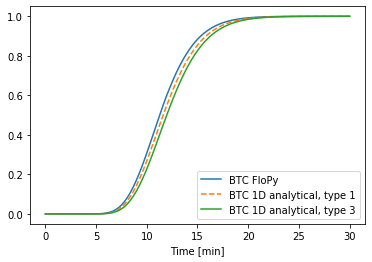

In [82]:
c1, = plt.plot(times/60, C_btc, label='BTC FloPy')
c2, = plt.plot(times/60, Conc_time_type1, '--', label='BTC 1D analytical, type 1')
c3, = plt.plot(times/60, Conc_time_type3, label='BTC 1D analytical, type 3')
plt.xlabel('Time [min]');

plt.legend(handles=[c1, c2, c3])

## Activity:
Using these code, evalute the concration profile along the column a few different times.

In [83]:
timestep = 10
# Call the FloPy model function
Conc_time_type1_x = analytical_model_1D_t1(x, times[timestep], v, al)
Conc_time_type3_x = analytical_model_1D_t3(x, times[timestep], v, al)

Time: 3.0 min


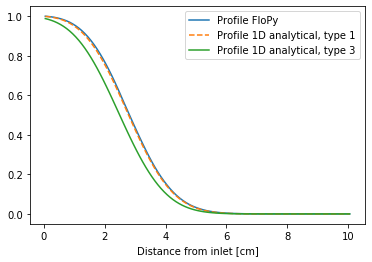

In [84]:
C_profile = conc[timestep, 0, 0, :]

c1, = plt.plot(x, C_profile, label='Profile FloPy')
c2, = plt.plot(x, Conc_time_type1_x, '--', label='Profile 1D analytical, type 1')
c3, = plt.plot(x, Conc_time_type3_x, label='Profile 1D analytical, type 3')
plt.xlabel('Distance from inlet [cm]');

plt.legend(handles=[c1, c2, c3])

print('Time: ' + str(times[timestep]/60) + ' min')

Time: 6.0 min


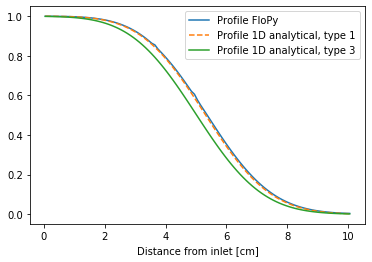

In [85]:
# Now a later time
timestep = 20
# Call the FloPy model function
Conc_time_type1_x = analytical_model_1D_t1(x, times[timestep], v, al)
Conc_time_type3_x = analytical_model_1D_t3(x, times[timestep], v, al)

C_profile = conc[timestep, 0, 0, :]

c1, = plt.plot(x, C_profile, label='Profile FloPy')
c2, = plt.plot(x, Conc_time_type1_x, '--', label='Profile 1D analytical, type 1')
c3, = plt.plot(x, Conc_time_type3_x, label='Profile 1D analytical, type 3')
plt.xlabel('Distance from inlet [cm]');

plt.legend(handles=[c1, c2, c3])

print('Time: ' + str(times[timestep]/60) + ' min')

Homework, explain why the model is a Type 1 inlet BC and not a Type 3.